In [1]:
import requests
from bs4 import BeautifulSoup as b

headers = requests.utils.default_headers()

In [2]:
# Assign the album link to base_link
base_link = 'http://www.absolutelyrics.com/lyrics/artist/taylor_swift'

page = requests.get(base_link)

In [3]:
soup = b(page.content, "html.parser")
soup

<!DOCTYPE html>

<html>
<head>
<title>Taylor Swift Lyrics - Absolute Lyrics</title>
<meta content="text/html; charset=utf-8" http-equiv="Content-type"/>
<meta content="Taylor Swift, lyrics" name="keywords"/>
<meta content="List all music lyrics for Taylor Swift, sort by album's release date with album cover and track list." name="description"/>
<link href="http://www.absolutelyrics.com/l/a2303" rel="shorturl" type="text/html"/>
<link href="http://www.absolutelyrics.com/l/a2303" rel="shortlink" type="text/html"/>
<link href="/static/style2.css" rel="stylesheet" type="text/css"/>
<script src="https://apis.google.com/js/plusone.js" type="text/javascript"></script>
<script src="/static/js2.js" type="text/javascript"></script>
<script>
  (function(i,s,o,g,r,a,m){i['GoogleAnalyticsObject']=r;i[r]=i[r]||function(){
  (i[r].q=i[r].q||[]).push(arguments)},i[r].l=1*new Date();a=s.createElement(o),
  m=s.getElementsByTagName(o)[0];a.async=1;a.src=g;m.parentNode.insertBefore(a,m)
  })(window,docum

In [4]:
lyric_base = 'http://www.absolutelyrics.com'

# Create a list of the paths to each song in the album
all_album_links = soup.find_all('li', class_='artist_albumlistitem')
all_album_links = [a.find('div', class_='artist_albumsonglist').find_all('li') for a in all_album_links]

In [5]:
lyric_base = 'http://www.absolutelyrics.com'

# Create a list of the paths to each song in the album
all_album_links = soup.find_all('li', class_='artist_albumlistitem')
all_album_links = [(a.find('div', class_ = 'artist_albuminfo').find('h3').text[:-8], a.find('div', class_='artist_albumsonglist').find_all('li')) for a in all_album_links]

def flatten(l):
    return [item for sublist in l for item in sublist]

all_links = flatten(all_album_links)
all_links = [a.find('a') for a in all_links]
all_links = [lyric_base + a['href'] for a in all_links if a is not None]
all_links

In [6]:
all_links = [(a[0], b) for a in all_album_links for b in a[1]]
all_links = [(a[0], a[1].find('a')) for a in all_links]
all_links = [(a[0], a[1].text[11:], lyric_base + a[1]['href']) for a in all_links if a[1] is not None and "unkno" not in a[0]]
all_links

[('Evermore',
  'Willow',
  'http://www.absolutelyrics.com/lyrics/view/taylor_swift/willow'),
 ('Evermore',
  'Champagne Problems',
  'http://www.absolutelyrics.com/lyrics/view/taylor_swift/champagne_problems'),
 ('Evermore',
  'Gold Rush',
  'http://www.absolutelyrics.com/lyrics/view/taylor_swift/gold_rush'),
 ('Evermore',
  "'Tis The Damn Season",
  "http://www.absolutelyrics.com/lyrics/view/taylor_swift/'tis_the_damn_season"),
 ('Evermore',
  'Tolerate It',
  'http://www.absolutelyrics.com/lyrics/view/taylor_swift/tolerate_it'),
 ('Evermore',
  'No Body, No Crime',
  'http://www.absolutelyrics.com/lyrics/view/taylor_swift/no_body,2c_no_crime'),
 ('Evermore',
  'Happiness',
  'http://www.absolutelyrics.com/lyrics/view/taylor_swift/happiness'),
 ('Evermore',
  'Dorothea',
  'http://www.absolutelyrics.com/lyrics/view/taylor_swift/dorothea'),
 ('Evermore',
  'Coney Island',
  'http://www.absolutelyrics.com/lyrics/view/taylor_swift/coney_island'),
 ('Evermore',
  'Ivy',
  'http://www.abs

In [7]:
import time 
import numpy as np 
from tqdm import tqdm 

all_songs = []

for link in tqdm(all_links): 
    page = requests.get(link[2])
    soup = b(page.content, 'html.parser')

    lyrics = soup.find('p', {'id': 'view_lyrics'}).text

    song = {
        'album': link[0],
        'title': link[1],
        'lyrics': lyrics
    }

    all_songs.append(song.copy())

all_songs

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [01:24<00:00,  1.85it/s]


[{'album': 'Evermore',
  'title': 'Willow',
  'lyrics': "\n\tI'm like the water when your ship rolled in that night\nRough on the surface but you cut through like a knife\nAnd if it was an open/shut case\nI never would've known from that look on your face\nLost in your current like a priceless wine\n\nThe more that you say, the less I know\nWherever you stray, I follow\nI'm begging for you to take my hand\nWreck my plans, that's my man\n\nLife was a willow and it bent right to your wind\nHead on the pillow, I could feel you sneaking in\nAs if you were a mythical thing\nLike you were a trophy or a champion ring\nAnd there was one prize I'd cheat to win\n\nThe more that you say, the less I know\nWherever you stray, I follow\nI'm begging for you to take my hand\nWreck my plans, that's my man\nYou know that my train could take you home\nAnywhere else is hollow\nI'm begging for you to take my hand\nWreck my plans, that's my man\n\nLife was a willow and it bent right to your wind\nThey count

In [8]:
import json
with open('./data.json', 'w') as f: 
    json.dump(all_songs, f)

In [9]:
import json
with open('./data.json', 'r') as f: 
    loaded_songs = json.load(f)

In [10]:
import re

def process_lyrics(song): 
    words = song['lyrics']
    words = words.replace('<br />', '')
    words = words.replace('\n', ' ')
    words = words.replace('\t', '')
    words = words.replace('+', '')
    words = re.sub(r'[^\w\s]', '', words)
    words = words.replace('\'', '')
    words = words.replace('"', '')
    words = words.replace('\r', '')
    words = words.replace('f_ck', 'fuck')
    words = words.replace('f_cked', 'fucked')
    words = words.replace('sh_t', 'shit')
    words = words.replace('b_tch', 'bitch')
    words = words.replace('b_ttons', 'buttons')
    words = words.replace('b_tt', 'butt')
    words = " ".join(words.split())
    words = re.sub(r'[\(\[].*?[\)\]]', '', words)
    words = words.replace('&#8', '')
    words = words.strip().lower()
    song['lyrics'] = words
    return song

loaded_songs = [process_lyrics(song) for song in loaded_songs]
loaded_songs

[{'album': 'Evermore',
  'title': 'Willow',
  'lyrics': 'im like the water when your ship rolled in that night rough on the surface but you cut through like a knife and if it was an openshut case i never wouldve known from that look on your face lost in your current like a priceless wine the more that you say the less i know wherever you stray i follow im begging for you to take my hand wreck my plans thats my man life was a willow and it bent right to your wind head on the pillow i could feel you sneaking in as if you were a mythical thing like you were a trophy or a champion ring and there was one prize id cheat to win the more that you say the less i know wherever you stray i follow im begging for you to take my hand wreck my plans thats my man you know that my train could take you home anywhere else is hollow im begging for you to take my hand wreck my plans thats my man life was a willow and it bent right to your wind they count me out time and time again life was a willow and it 

In [11]:
import pandas as pd

df = pd.DataFrame(loaded_songs)
df.head()

,album,title,lyrics
0,Evermore,Willow,im like the water when your ship rolled in tha...
1,Evermore,Champagne Problems,you booked the night train for a reason so you...
2,Evermore,Gold Rush,gleaming twinkling eyes like sinking ships on ...
3,Evermore,'Tis The Damn Season,if i wanted to know who you were hanging with ...
4,Evermore,Tolerate It,i sit and watch you reading with your head low...


In [12]:
df['album'].value_counts()

Lover                                                        18
Evermore                                                     17
Folklore                                                     17
Speak Now                                                    17
1989                                                         16
Red                                                          16
Fearless                                                     16
Reputation                                                   15
Taylor Swift                                                 14
Sounds of the Season: The Taylor Swift Holiday Collection     6
Beautiful Eyes                                                5
Name: album, dtype: int64

In [13]:
df['title'] = df['title'].apply(lambda x: str(x).strip('\"'))
df['album'] = df['album'].apply(lambda x: str(x).strip('\"'))
df['lyrics'] = df['lyrics'].apply(lambda x: str(x).strip('\"'))

In [14]:
import nltk
from nltk.corpus import stopwords

swords = stopwords.words('english')
swords += ['im', 'like', 'youre', 'dont']
swords = [sword.replace("'", "") for sword in swords]
swords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'youre',
 'youve',
 'youll',
 'youd',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'shes',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'thatll',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'fe

In [15]:
top_counts = pd.Series([word for word in " ".join(df['lyrics'].tolist()).split(" ") if word not in swords]).value_counts()
top_counts

know        436
never       319
love        250
time        232
oh          232
           ... 
ease          1
traits        1
argue         1
blankets      1
unbroken      1
Length: 3307, dtype: int64

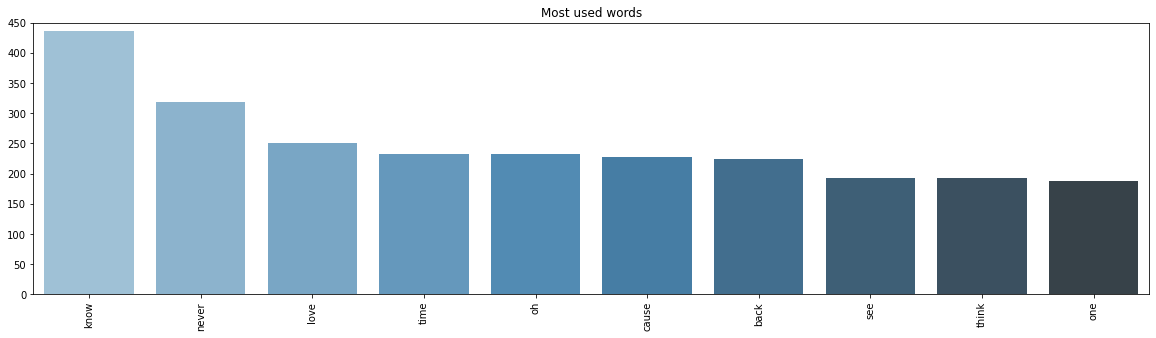

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 5))
sns.barplot(x=top_counts.index[:10], y=top_counts[:10], palette='Blues_d')
plt.title('Most used words')
plt.ylim(ymin=0,ymax=450)
plt.xticks(rotation=90)
plt.show()

In [17]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\T450\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [18]:
# Sentiment Analysis of lyrics using VADER

from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer() 
df['scores'] = df['lyrics'].apply(lambda l: sid.polarity_scores(l)['compound'])
df['sentiment'] = df['scores'].apply(lambda x: 'positive' if x >= 0 else 'negative')
df.head()

,album,title,lyrics,scores,sentiment
0,Evermore,Willow,im like the water when your ship rolled in tha...,0.9776,positive
1,Evermore,Champagne Problems,you booked the night train for a reason so you...,-0.5210,negative
2,Evermore,Gold Rush,gleaming twinkling eyes like sinking ships on ...,0.9979,positive
3,Evermore,'Tis The Damn Season,if i wanted to know who you were hanging with ...,-0.6185,negative
4,Evermore,Tolerate It,i sit and watch you reading with your head low...,0.9931,positive


In [19]:
df['sentiment'].value_counts() 

positive    110
negative     47
Name: sentiment, dtype: int64

In [20]:
red_df = df[df['album']=='Red']

In [21]:
red_df.head(20)

,album,title,lyrics,scores,sentiment
83,Red,State of Grace,im walking fast through the traffic lights bus...,0.9884,positive
84,Red,Red,verse 1 loving him is like driving a new maser...,0.9979,positive
85,Red,Treacherous,put your lips close to mine as long as they do...,-0.9659,negative
86,Red,I Knew You Were Trouble,once upon a time a few mistakes ago i was in y...,-0.9992,negative
87,Red,All Too Well,i walked through the door with you the air was...,0.9905,positive
88,Red,22,it feels like a perfect night to dress up like...,0.9968,positive
89,Red,I Almost Do,i bet this time of night youre still up i bet ...,0.8484,positive
90,Red,We Are Never Ever Getting Back Together,i remember when we broke up the first time say...,0.9952,positive
91,Red,Stay Stay Stay,im pretty sure we almost broke up last night i...,0.5598,positive
92,Red,The Last Time,gary lightbody found myself at your door just ...,0.8299,positive


In [22]:
common_words = pd.Series([word for word in " ".join(red_df['lyrics'].tolist()).split(" ") if word not in swords]).value_counts()
common_words

know         76
time         56
never        54
oh           50
ever         38
             ..
plaid         1
self          1
paralyzed     1
fly           1
whats         1
Length: 732, dtype: int64

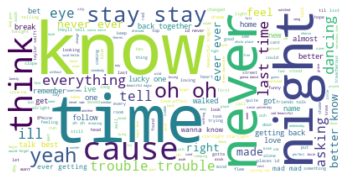

In [23]:
# Red lyrics wordcloud
from wordcloud import WordCloud, STOPWORDS

text = " ".join(words for words in red_df.lyrics)
wordcloud = WordCloud(background_color='white', stopwords=swords).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

C:\Users\T450\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [25]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [26]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [27]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [28]:
bert_model_name = 'albert_en_base'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/albert_en_base/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/albert_en_preprocess/3


In [29]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [30]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [   2   48   25  145   40 5289 1308  187    3    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [31]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [32]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/albert_en_base/2
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.5641985  -0.5833792   0.8920309  -0.8834061  -0.5900784  -0.97489256
  0.5973348  -0.5650731   0.65825915 -0.99990517  0.92246944  0.5789037 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.93791497  0.28508726 -0.37701437 ...  0.1940772  -1.1221757
   0.5021093 ]
 [ 1.6732259  -1.2593408   0.98551595 ... -0.03488618  2.440246
  -1.4151807 ]
 [ 1.5726154  -0.7276683  -0.61325073 ...  1.1369406  -0.24407133
  -0.2023898 ]
 ...
 [ 0.46375114  0.7806508  -0.00772671 ...  0.36924613  0.9916427
  -1.1032671 ]
 [ 0.44642666  0.85889935  0.020444   ...  0.4076969   1.086323
  -1.0217946 ]
 [ 0.46782196  0.8818824   0.02625042 ...  0.44045734  1.1098759
  -1.016714  ]]


In [33]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [34]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.31896508]], shape=(1, 1), dtype=float32)


In [35]:
tf.keras.utils.plot_model(classifier_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [36]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [37]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [38]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [39]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/albert_en_base/2
Epoch 1/5
625/625 [==============================] - 29519s 47s/step - loss: 0.3976 - binary_accuracy: 0.8085 - val_loss: 0.2993 - val_binary_accuracy: 0.8628
Epoch 2/5
625/625 [==============================] - 26332s 42s/step - loss: 0.2617 - binary_accuracy: 0.8913 - val_loss: 0.3078 - val_binary_accuracy: 0.8790
Epoch 3/5
625/625 [==============================] - 24753s 40s/step - loss: 0.1706 - binary_accuracy: 0.9379 - val_loss: 0.4399 - val_binary_accuracy: 0.8760
Epoch 4/5
625/625 [==============================] - 24951s 40s/step - loss: 0.1010 - binary_accuracy: 0.9704 - val_loss: 0.5478 - val_binary_accuracy: 0.8764
Epoch 5/5
625/625 [==============================] - 25143s 40s/step - loss: 0.0551 - binary_accuracy: 0.9872 - val_loss: 0.6450 - val_binary_accuracy: 0.8842


In [40]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [41]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [42]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [43]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.996863
input: The movie was great!           : score: 0.998904
input: The movie was meh.             : score: 0.000621
input: The movie was okish.           : score: 0.004437
input: The movie was terrible...      : score: 0.678202

Results from the model in memory:
input: this is such an amazing movie! : score: 0.996863
input: The movie was great!           : score: 0.998904
input: The movie was meh.             : score: 0.000621
input: The movie was okish.           : score: 0.004437
input: The movie was terrible...      : score: 0.678202



In [ ]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)